In [1]:
from __future__ import print_function

from collections import Counter
import json

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

from abtools import color

from utils import pair, plots, vrc01

% matplotlib inline

## JSON files

JSON files, which contain annotated mAb sequence data, are provided in the repository for each immunization group. These JSON files contain the output produced by AbStar (https://github.com/briney/abstar), as well as subject and immunization group assignments. To start, we'll just read in the JSON data for each immunzation group:

In [2]:
gt8_jsons = json.load(open('./jsons/gt8.json'))
gt8x3_jsons = json.load(open('./jsons/gt8x3.json'))
gt3_60mer_jsons = json.load(open('./jsons/gt3_60mer.json'))
gt3_sosip_jsons = json.load(open('./jsons/gt3_sosip.json'))
gt8_gt3_jsons = json.load(open('./jsons/gt8-gt3.json'))
gt8_gt3_sosip_jsons = json.load(open('./jsons/gt8-gt3-sosip.json'))

## Antibody pairs

Using the JSON data we just parsed, we can now group paired heavy and light chains. To do this, we'll use the `assign_pairs()` function, which will return a list of `Pair` objects, each corresponding to a single antibody pair. In the case of unpaired heavy or light chains, the `Pair` object would only contain a single antibody chain.

In [3]:
gt8 = pair.assign_pairs(gt8_jsons)
gt8x3 = pair.assign_pairs(gt8x3_jsons)
gt3_60mer = pair.assign_pairs(gt3_60mer_jsons)
gt3_sosip = pair.assign_pairs(gt3_sosip_jsons)
gt8_gt3 = pair.assign_pairs(gt8_gt3_jsons)
gt8_gt3_sosip = pair.assign_pairs(gt8_gt3_sosip_jsons)

For some of the plots we're going to make, we'd like to have the antibody sequences within each immunization group separated by animal. `group_by_subject()` takes a list of antibody pairs corresponding to an immunization group and returns a dictionary with subject names as keys and lists of pairs as values:

In [4]:
def group_by_subject(pairs):
    grouped = {}
    for subject in list(set([p.subject for p in pairs])):
        grouped[subject] = [p for p in pairs if p.subject == subject]
    return grouped

In [5]:
gt8_bysubject = group_by_subject(gt8)
gt8x3_bysubject = group_by_subject(gt8x3)
gt3_60mer_bysubject = group_by_subject(gt3_60mer)
gt3_sosip_bysubject = group_by_subject(gt3_sosip)
gt8_gt3_bysubject = group_by_subject(gt8_gt3)
gt8_gt3_sosip_bysubject = group_by_subject(gt8_gt3_sosip)

## Figure 3A: Frequency of VRC01-like sequences

Figure 3A is a bubble plot showing the frequency of VRC01-like pairs, of the total number of paired antibody sequences. Each bubble represents a single animal, and the area of the bubble is proportional to the number of sequences obtained from that animal. To prevent the bubbles from obscuring each other while still making the bubbles easily visible, bubbles are jittered along the x-axis, the fill is transparent and the border is opaque.

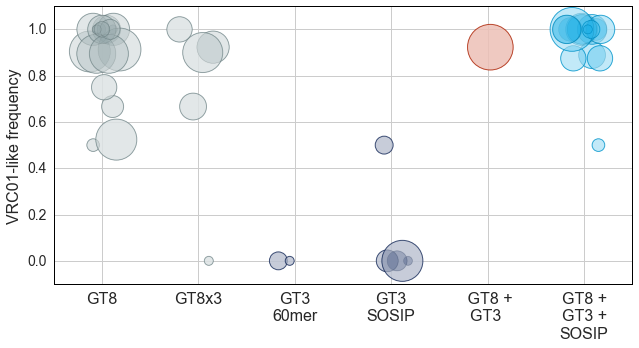

In [6]:
_colors = ['#8da2a5', '#8da2a5', '#203669', '#203669', '#c22b0a', '#0DABE6']
_xs = [1, 2, 3, 4, 5, 6]
_experiments = [gt8_bysubject,
                gt8x3_bysubject,
                gt3_60mer_bysubject,
                gt3_sosip_bysubject,
                gt8_gt3_bysubject,
                gt8_gt3_sosip_bysubject]

xs = []
ys = []
sizes = []
colors = []

# ensure that the jitter will be the same each time this block is run
np.random.seed(1234)

# calculate the frequency of VRC01-like pairs (of the total number of pairs) for each animal
for exp, x, c in zip(_experiments, _xs, _colors):
    for subject, pairs in exp.items():
        total = len([p for p in pairs if p.is_pair])
        if total == 0:
            continue
        vrc01_like = len([p for p in pairs if p.vrc01_like])
        ys.append(1. * vrc01_like / total)
        # data points are randomly jittered to reduce overlap
        jitter = np.random.uniform(-0.2, 0.2)
        xs.append(x + jitter)
        sizes.append(80 * total)
        colors.append(c)


# make the figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 5))

# less transparent borders
border = plt.scatter(xs, ys, c='w', s=sizes, linewidths=1, edgecolor=colors)
border.set_alpha(0.8)

# more transparent fill
fill = plt.scatter(xs, ys, c=colors, s=sizes)
fill.set_alpha(0.25)

# adjust tick and axis labels
ax = plt.gca()
ax.set_xticks(range(1, 7))
ax.set_xticklabels(['GT8', 'GT8x3', 'GT3\n60mer', 'GT3\nSOSIP', ' GT8 +\nGT3 ', 'GT8 +\nGT3 +\nSOSIP'], size=16)
ax.tick_params(axis='y', labelsize=14)
plt.ylabel('VRC01-like frequency', fontsize=16)

# set axis limits
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(0.5, 6.5)

# make the plot border visible and black
for position in ['right', 'left', 'top', 'bottom']:
        ax.spines[position].set_visible(True)
        ax.spines[position].set_color('k')
        
plt.tight_layout()
plt.show()
# plt.savefig('./fig3A.pdf')

# for any of the plots in this notebook, if you'd like to save the figure
# instead of showing it inline, comment out the `plt.show()` line above and
# uncomment the `plt.savefig('./gif3A.pdf')` line. The figure will be saved
# as a PDF to the repo directory. If you'd like a PNG or JPG instead of PDF,
# just change the file extension in the plt.savefig() argument.

## Figure 3B: Nucleotide mutations in elicited VRC01-like pairs

Figure 3B is a violin plot showing the distribution of heavy chain nucleotide mutations in VRC01-like antibody pairs obtained from each immunization group.

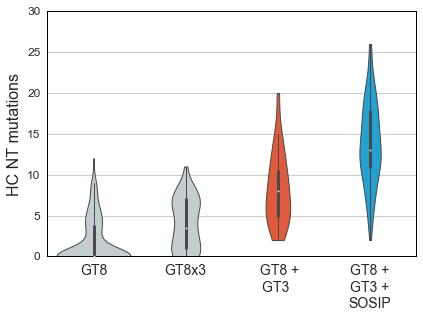

In [7]:
sns.set_style('whitegrid')

_colors = ['#C3CED0', '#C3CED0', '#F44D28', '#0DABE6']
_exp_names = ['GT8', 'GT8x3', ' GT8 +\nGT3 ', 'GT8 +\nGT3 +\nSOSIP']
_experiments = [gt8,
                gt8x3,
                gt8_gt3,
                gt8_gt3_sosip]

xs = []
ys = []

# calculate the number of nucleotide mutations for each sequence
# in each immunization group
for i, pairs in enumerate(_experiments):
    vrc01_like = [p for p in pairs if p.vrc01_like]
    mcounts = [p.heavy['var_muts_nt']['num'] for p in vrc01_like]
    xs.extend([_exp_names[i]] * len(mcounts))
    ys.extend(mcounts)

# make the figure
fig = plt.figure(figsize=(6, 4.5))
ax = sns.violinplot(x=xs, y=ys, order=_exp_names, palette=_colors, inner='box', cut=0, linewidth=1, saturation=0.8)

# make the plot borders visible and black
for position in ['right', 'left', 'top', 'bottom']:
        ax.spines[position].set_visible(True)
        ax.spines[position].set_color('k')

# set axis limits
ax.set_ylim([0, 30])

# adjust tick and axis labels
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)
plt.ylabel('HC NT mutations', size=16)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3B.pdf')

## Figure 3C: Amino acid mutations in elicited VRC01-like pairs

Figure 3C is a violin plot showing the distribution of amino acid mutations in VRC01-like antibody pairs obtained from each immunization group.

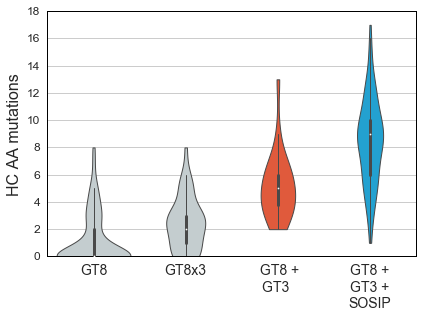

In [8]:
sns.set_style('whitegrid')

_colors = ['#C3CED0', '#C3CED0', '#F44D28', '#0DABE6']
_exp_names = ['GT8', 'GT8x3', ' GT8 +\nGT3 ', 'GT8 +\nGT3 +\nSOSIP']
_experiments = [gt8,
                gt8x3,
                gt8_gt3,
                gt8_gt3_sosip]

xs = []
ys = []

# calculate the number of nucleotide mutations for each sequence
# in each immunization group
for i, pairs in enumerate(_experiments):
    vrc01_like = [p for p in pairs if p.vrc01_like]
    mcounts = [p.heavy['var_muts_aa']['num'] for p in vrc01_like]
    xs.extend([_exp_names[i]] * len(mcounts))
    ys.extend(mcounts)

# make the figure
fig = plt.figure(figsize=(6, 4.5))
ax = sns.violinplot(x=xs, y=ys, order=_exp_names, palette=_colors, inner='box', cut=0, linewidth=1, saturation=0.8)

# make the plot borders visible and black
for position in ['right', 'left', 'top', 'bottom']:
        ax.spines[position].set_visible(True)
        ax.spines[position].set_color('k')

# set axis limits
ax.set_ylim([0, 18])

# adjust tick and axis labels
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=14)
plt.ylabel('HC AA mutations', size=16)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3C.pdf')

## Figure 3D: VRC01-class mutation frequency in elicited antibodies

Figure 3D contains four panels, with each panel showing the mutation 'trajectory' with respect to mature VRC01-class antibodies. Essentially, we'd like to see how strongly the vaccine-induced somatic mutation is pushing these sequences toward mature VRC01-class antibodies.  
  
We compute the frequency of 'VRC01-class' mutations (mutations shared with at least one of the following VRC01-class antibodies: VRC01, PGV04, VRC-CH31, 3BNC60, 12A12 and PGV20). We must first make a non-redundant list of all of the VRC01-class mutations, counting only mutations in the Variable gene region:

In [9]:
vrc01_class_mutations = vrc01.get_vrc01_class_mutations()

In addition to determining the frequency of VRC01-class mutations in our panel of elicited antibodies, we'd like to determine how frequently VRC01-class mutations occur by chance. In order to do this, we generated 1,000 synthetic antibody sequences from each of two healthy, non-HIV-infected individuals using the actual VH1-2 mutation probability distribution in each individual. Mutations in the synthetic antibody sequences (as well as the synthetic sequences themselves) are included in the repo:

In [10]:
# Donor 5684
d5684_mutations = []
with open('./synthetic_antibodies/d5684_mutations.txt') as f:
    for line in f:
        d5684_mutations.append(line.strip().split())
# there are actually 1920 synthetic sequences from donor 5684,
# but we only need the first 1000
d5684_mutations = d5684_mutations[:1000]


# Donor 6471
d6471_mutations = []
with open('./synthetic_antibodies/d6471_mutations.txt') as f:
    for line in f:
        d6471_mutations.append(line.strip().split())

# combine synthetic mutations from both donors
synth_mutations = d5684_mutations + d6471_mutations

Now that we have the synthetic mutations, we can iterate through them temporally (taking the first mutation from each sequence, then the first two mutations, etc.) and determine the frequency of VRC01-class mutations as the antibodies mature.

In [11]:
mean = [0, ]
ci_min = [0, ]
ci_max = [0, ]

# iterate temporally through the mutations - take the first mutation,
# then the first two, etc...
for i in range(1, 21):
    vrc01_class = []
    for sm in synth_mutations:
        # only sample sequences that have at least i mutations
        if len(sm) < i:
            continue
        vrc01_class.append(sum([m in vrc01_class_mutations for m in sm[:i]]))
    # calculate the mean and 95% CI for the frequency of VRC01-class mutations
    n, min_max, _mean, var, skew, kurt = stats.describe(vrc01_class)
    std = np.sqrt(var)
    _ci_min, _ci_max = stats.norm.interval(0.95, loc=_mean, scale=std / np.sqrt(len(vrc01_class)))
    mean.append(_mean)
    ci_min.append(_ci_min)
    ci_max.append(_ci_max)

# in order to center the squares in our 2D histogram, we need to offset
# each datapoint by 0.5
rand_xs = [x + 0.5 for x in range(len(mean))]
mean = [m + 0.5 for m in mean]
ci_min = [c + 0.5 for c in ci_min]
ci_max = [c + 0.5 for c in ci_max]

### Immunization group: GT8

Plot, as a 2-dimensional histogram, the frequency of VRC01-class mutations in mice immunized once with eOD-GT8.

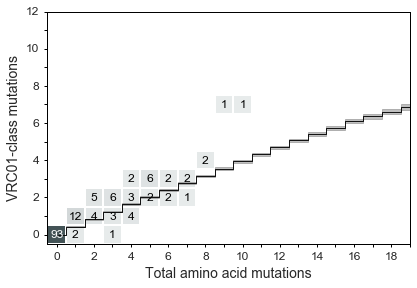

In [12]:
# determine the number of VRC01-class and total mutations in elicited antibodies
vrc01_class, total = vrc01.vrc01_class_mutation_count([p.heavy for p in gt8 if p.vrc01_like])

# minval=0.05 ensures that the lightest boxes are still distinguishable from background
cmap = color.truncate_colormap(color.cmap_from_color('#435356'), minval=0.05)

# plot the frequency of VRC01-class mutation in the GT8 immunization group
f, ax = plt.subplots()
plots.shared_mutation_2dhist(total, vrc01_class, cmap, ax)

# plot the frequency of random VRC01-class mutation, with 95% CIs
plots.fill_between_steps(ax, rand_xs, ci_max, ci_min)
plt.step(rand_xs, mean, where='mid', alpha=0.9, c='k', linewidth=1)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3D_GT8.pdf')

### Immunization group: GT8x3

Plot, as a 2-dimensional histogram, the frequency of VRC01-class mutations in mice immunized three times with eOD-GT8.

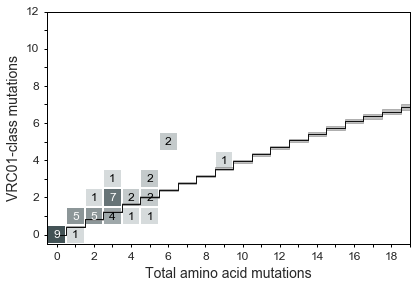

In [13]:
# determine the number of VRC01-class and total mutations in elicited antibodies
vrc01_class, total = vrc01.vrc01_class_mutation_count([p.heavy for p in gt8x3 if p.vrc01_like])

# minval=0.05 ensures that the lightest boxes are still distinguishable from background
cmap = color.truncate_colormap(color.cmap_from_color('#435356'), minval=0.05)

# plot the frequency of VRC01-class mutation in the GT8 immunization group
f, ax = plt.subplots()
plots.shared_mutation_2dhist(total, vrc01_class, cmap, ax)

# plot the frequency of random VRC01-class mutation, with 95% CIs
plots.fill_between_steps(ax, rand_xs, ci_max, ci_min)
plt.step(rand_xs, mean, where='mid', alpha=0.9, c='k', linewidth=1)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3D_GT8x3.pdf')

### Immunization group: GT8 + GT3

Plot, as a 2-dimensional histogram, the frequency of VRC01-class mutations in mice immunized once with eOD-GT8 and boosted once with BG505-GT3.

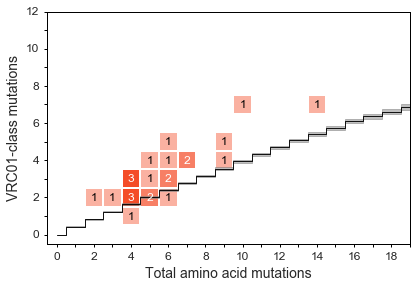

In [14]:
# determine the number of VRC01-class and total mutations in elicited antibodies
vrc01_class, total = vrc01.vrc01_class_mutation_count([p.heavy for p in gt8_gt3 if p.vrc01_like])

# minval=0.05 ensures that the lightest boxes are still distinguishable from background
cmap = color.truncate_colormap(color.cmap_from_color('#f44d28'), minval=0.05)

# plot the frequency of VRC01-class mutation in the GT8 immunization group
f, ax = plt.subplots()
plots.shared_mutation_2dhist(total, vrc01_class, cmap, ax)

# plot the frequency of random VRC01-class mutation, with 95% CIs
plots.fill_between_steps(ax, rand_xs, ci_max, ci_min)
plt.step(rand_xs, mean, where='mid', alpha=0.9, c='k', linewidth=1)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3D_GT8+GT3.pdf')

### Immunization group: GT8 + GT3 + N276 SOSIP

Plot, as a 2-dimensional histogram, the frequency of VRC01-class mutations in mice immunized once with eOD-GT8, boosted once with BG505-GT3 and boosted twice with N276 SOSIP.

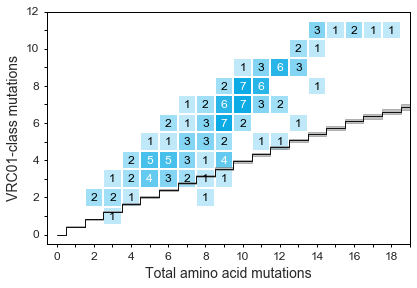

In [15]:
# determine the number of VRC01-class and total mutations in elicited antibodies
vrc01_class, total = vrc01.vrc01_class_mutation_count([p.heavy for p in gt8_gt3_sosip if p.vrc01_like])

# minval=0.05 ensures that the lightest boxes are still distinguishable from background
cmap = color.truncate_colormap(color.cmap_from_color('#0dabe6'), minval=0.05)

# plot the frequency of VRC01-class mutation in the GT8 immunization group
f, ax = plt.subplots()
plots.shared_mutation_2dhist(total, vrc01_class, cmap, ax)

# plot the frequency of random VRC01-class mutation, with 95% CIs
plots.fill_between_steps(ax, rand_xs, ci_max, ci_min)
plt.step(rand_xs, mean, where='mid', alpha=0.9, c='k', linewidth=1)

plt.tight_layout()
plt.show()
# plt.savefig('./fig3D_GT8+GT3+SOSIP.pdf')

## Figure 3E: Location of VRC01-class and non-VRC01-class mutations

Figure 3E is a 'pixel plot' showing the distribution of mutations in vaccine-elicited VRC01-like antibody pairs. Pixel plots are similar to multiple sequence alignments, but instead of showing the actual residues in the alignment, matches with the reference are transparent and mismatches are highlighted as colored pixels. As in an MSA, the x-axis represents position in the alignment (the second column is the second position in the antibody sequence) and the y-axis represents the sequences themselves (the second row is the the second sequence). In our case, VRC01-class mutations are colored blue and non-VRC01-class mutations are black. To save the figure instead of just plotting it inline, simply uncomment the `figfile` argument.

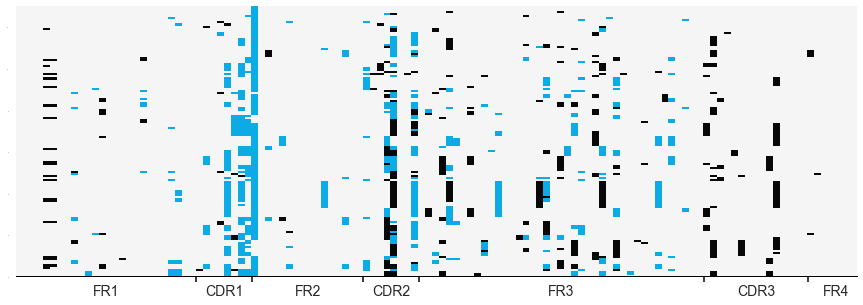

In [16]:
mut_positions = vrc01.vrc01_class_mutation_positions([p.heavy for p in gt8_gt3_sosip if p.vrc01_like])
cmap = ListedColormap(['#F5F5F5', '#080808', '#0DABE6', '#0DABE6'])
plots.pixel_plot(mut_positions,
                 cmap,
#                  figfile='./vax_mutation_pixel.pdf'
                )

## Figure 3F: Location of naturally occuring random SHM in VH1-2 heavy chains

We next want to compare the location distribution of vaccine-induced SHM in VRC01-like antibody pairs to the location distribution of naturally occurring SHM in heavy chains encoding VH1-2. This will verify that the high level of VRC01-class mutation observed in vaccine-elicited antibodies is due to vaccination and not caused by an inherent tendency of VH1-2 heavy chains to naturally incofrporate VRC01-class mutations at a high frequency. First, we randomly select 75 synthetic sequences from each of the two healthy, HIV-uninfected donors:

In [17]:
synthetic_mutations = list(np.random.choice(d5684_mutations, size=75)) + \
                      list(np.random.choice(d6471_mutations, size=75))

Before we can make a pixel plot of the naturally occuring mutations, we need to normalize the number of mutations per 'sequence' to what we observe in the vaccine-elicited antibodies. Because we generated our synthetic sequences with as many mutations as the natural mutation distribution would allow, they contain many more mutations than the vaccine-elicited antibodies, as is apparent by plotting the mutation distribtion of the two sets of sequences (vaccine-elicited in blue, synthetic in red):

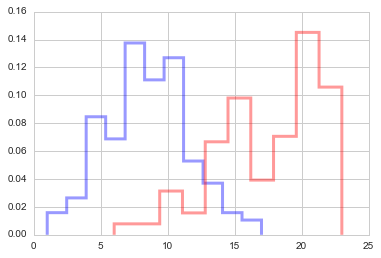

In [19]:
vax_mut_counts = [p.heavy['var_muts_aa']['num'] for p in gt8_gt3_sosip if p.vrc01_like]
synthetic_mut_counts = [len(m) for m in synthetic_mutations]

sns.set_style('whitegrid')
sns.distplot(vax_mut_counts,
             kde=False,
             norm_hist=True,
             hist_kws={"histtype": "step", "linewidth": 3, "color": "b"})
sns.distplot(synthetic_mut_counts,
             kde=False,
             norm_hist=True,
             hist_kws={"histtype": "step", "linewidth": 3, "color": "r"})
plt.show()

We can adjust the number of mutations in each synthetic sequence by selecting a subset of mutations in each synthetic sequence using a probability distribution based on mutation frequencies in our set of vaccine-induced sequences. While we're at it, we're going to convert the synthetic sequences (which are curently being represented as a list of mutations) into actual amino acid sequences. Plotting the mutation frequency distribution after adjustment shows a much better mutation distribution in the synthetic sequences.

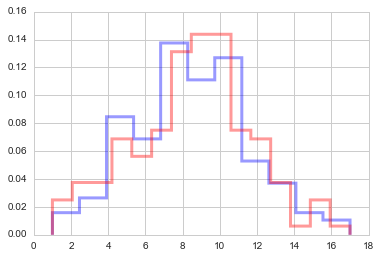

In [20]:
# calculate the mutation frequency probability distribution in vax-induced antibodies 
vax_mut_counter = Counter([p.heavy['var_muts_aa']['num'] for p in gt8_gt3_sosip if p.vrc01_like])
vax_mut_counter_norm = {k: 1. * v / sum(vax_mut_counter.values()) for k, v in vax_mut_counter.items()}
vax_mut_probs = [vax_mut_counter_norm[m] for m in sorted(vax_mut_counter_norm.keys())]

# normalize the number of mutations in each synthetic sequence
# and convert each synthetic seqeunce into an amino acid sequence
glvrc01 = vrc01.get_vrc01_germline_sequence(vgene_only=False)
synthetic_sequences = []
norm_synthetic_mutation_counts = []
for m in synthetic_mutations:
    mut_num = int(np.random.choice(sorted(vax_mut_counter.keys()), p=vax_mut_probs))
    _mutations = m[:mut_num]
    norm_synthetic_mutation_counts.append(len(_mutations))
    # convert the list of mutations into an actual amino acid sequence
    seq = glvrc01
    for _m in _mutations:
        pos = int(_m[:-1]) - 1
        res = _m[-1]
        seq = seq[:pos] + res + seq[pos + 1:]
    synthetic_sequences.append({'seq_id': 1, 'vdj_aa': seq})

# plot the distribution of mutation frequencies in vax-induced
# and synthetic sequences
sns.set_style('whitegrid')
sns.distplot(vax_mut_counts,
             kde=False,
             norm_hist=True,
             hist_kws={"histtype": "step", "linewidth": 3, "color": "b"})
sns.distplot(norm_synthetic_mutation_counts,
             kde=False,
             norm_hist=True,
             hist_kws={"histtype": "step", "linewidth": 3, "color": "r"})
plt.show()

We can now make our pixel plot of synthetic mutations. Note that because we randomly selected a subset of synthetic sequences to make this plot, the plot may not identically match the figure in the maunscript. Rerunning the code starting at the beginning of Figure 3F will give you an idea of the variation produced by this random sampling. To save the figure instead of just plotting it inline, simply uncomment the `figfile` argument.

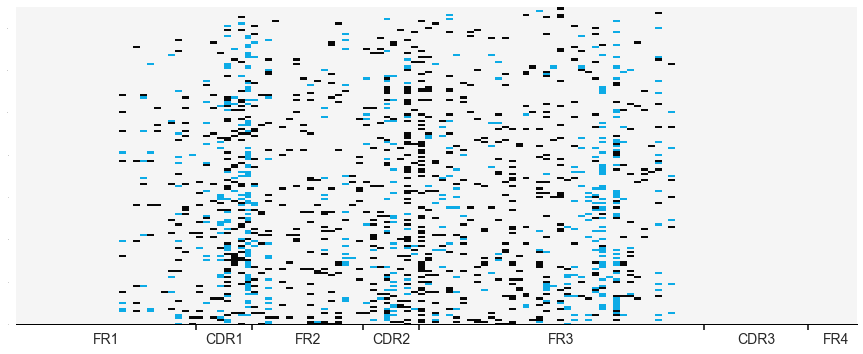

In [21]:
mut_positions = vrc01.vrc01_class_mutation_positions(synthetic_sequences)
cmap = ListedColormap(['#F5F5F5', '#080808', '#0DABE6', '#0DABE6'])
plots.pixel_plot(mut_positions,
                 cmap,
#                  figfile='./synthetic_mutation_pixel.pdf'
                )